# Install Packages

In [1]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
# tf.compat.v1.disable_v2_behavior()
print(tf.__version__)

import numpy as np

tf.get_logger().setLevel('ERROR')

2.15.0


Install TensorFlow Privacy.

In [2]:
!pip install tensorflow-privacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 34.9 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f8188ffc2f1c22736ca7d3c22c689041f4f543bb522b589c287600435c983e70
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: p

In [3]:
!pip install imutils
from imutils import paths

# Mount Google Drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive/kaggle/kaggleTrainingSet/trainingSet/trainingSet
mnist_path ='/content/drive/MyDrive/kaggle/kaggleTrainingSet/trainingSet/trainingSet'

0  1  2  3  4  5  6  7	8  9


# Create Clients

In [6]:
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

In [106]:
batch_size = 30
TOTAL_CLIENTS = 100
comms_round = 30

In [8]:

def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as
                data shards - tuple of images and label lists.
        args:
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1

    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
#     random.shuffle(data)  # <- IID

    # sort data for non-iid
#     max_y = np.argmax(label_list, axis=-1)
#     sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
#     data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients

    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

def batch_data(data_shard, bs=batch_size, flip=False):
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    data = np.array(data)

    labels = list(label)

    if flip:
        labels = shuffle(labels)

    labels = np.array(labels)
    data = np.array(list(data))

    assert(data.shape[0] == labels.shape[0])

#     data = tf.constant(data)
#     labels = tf.constant(labels)

    dataset = tf.data.Dataset.from_tensor_slices((data, labels))

    X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(data,
                                                    label,
                                                    train_size=0.9,
                                                    test_size=0.1,
                                                    random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((np.array(list(X_data_train)), np.array(list(y_data_train))))
    test_dataset = tf.data.Dataset.from_tensor_slices((np.array(list(X_data_test)), np.array(list(y_data_test))))
    return (train_dataset.shuffle(len(y_data_train)).batch(bs), test_dataset.batch(bs), y_data_test)


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs


    if debug:
        print('global_count', global_count, 'local_count', local_count, 'bs', bs)

    return local_count/global_count

def fed_avg(weights):
    assert(len(weights) > 0)
    n_layers = len(weights[0])

    avg_weights = list()

    for layer in range(n_layers):
        layer_weights = np.array([w[layer] for w in weights])
        mean_layer_weights = np.mean(layer_weights, axis = 0)
        avg_weights.append(mean_layer_weights)

    return avg_weights



def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('round/client: {} | acc: {:.3%} | loss: {}'.format(comm_round, acc, loss))
    return acc, loss

# Create Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation

class SimpleMLP:

    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes, use_bias=True, name="last_dense"))
        model.add(Activation("softmax"))
        return model


In [10]:
import cv2
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [11]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255

train_data = train_data.reshape(train_data.shape[0], 28*28)
test_data = test_data.reshape(test_data.shape[0], 28*28)

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

train_data.shape, train_labels.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 784), (60000, 10))

In [12]:
X_train, X_test, y_train, y_test = train_data, test_data, train_labels, test_labels

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(60000, 10000, 60000, 10000)

In [14]:
clients = create_clients(X_train, y_train, num_clients=TOTAL_CLIENTS, initial='client')

In [15]:
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 28.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl size=11756983 sha256=8b52407f7f75f25bef4175fdc732477930aec81c343032f41adc3527ae88be8e
  Stored in directory: /root/.cache/pip/wheels/a7/83/5a/c704868d367ace343ac89b928f3d937313a5b5fb5731483705
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


# Heatmap of non-IID data

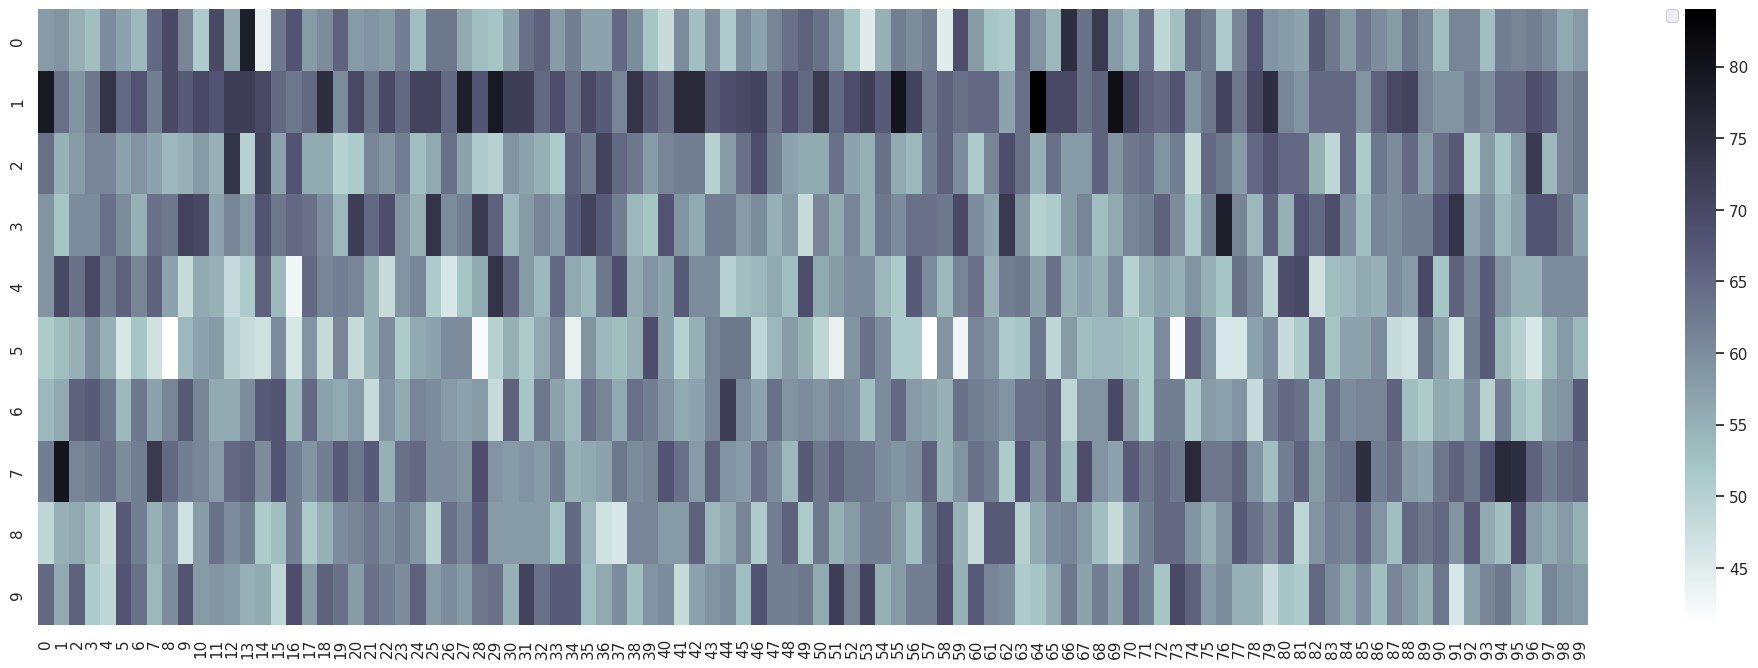

In [16]:
from collections import Counter
import seaborn as sns

def one_hot_to_numbers(labels):
    numbers = []
    for one_hot in labels:
        number = np.argmax(one_hot)
        numbers.append(number)
    return numbers

def number_count_tuples(numbers):
    count_dict = dict(Counter(numbers))
    count_tuples = [(number, count) for number, count in count_dict.items()]
    return count_tuples

distrib = [[0]*TOTAL_CLIENTS for _ in range(10)]
client_id = 0
for client_name in clients.keys():
    client_data = clients[client_name]
    _, labels = zip(*client_data)
    numbers = one_hot_to_numbers(labels)
    count_tuples = number_count_tuples(numbers)

    for item in count_tuples:
        distrib[item[0]][client_id] = item[1]

    client_id += 1

    distrib = np.array(distrib)
# print(distrib)
sns.set(rc={'figure.figsize':(25,8)})
sns.heatmap(distrib, cmap='bone_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
# plt.savefig("heatmap.png")

# Create byzantine participants

In [107]:
frac = 0.2
BYZANTINE_CNT = int(frac*TOTAL_CLIENTS)

In [108]:
import random
from sklearn.utils import shuffle

#process and batch the training data for each client
# and pick one owner that is not byzantine
client_names = list(clients.keys())
owner_idx = random.randint(0,len(client_names))
owner_name = client_names[owner_idx]

clients_batched = dict()
flipped = []
for (client_name, data) in clients.items():
    flip = True if client_name != owner_name and random.randint(0,TOTAL_CLIENTS) < BYZANTINE_CNT else False
    if flip:
        flipped.append(client_name)
    clients_batched[client_name] = batch_data(data, flip=flip)

print('flipped:', len(flipped))

#process and batch the test set
test_batched = tf.data.Dataset.from_tensor_slices((np.array(list(X_test)), np.array(list(y_test)))).batch(len(y_test))

flipped: 18


In [109]:
PRIVATIZE = False

# FedAvg

In [110]:
# FedAvg for complete weights

def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final


def sum_scaled_weights(weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''

    avg_grad = tf.math.reduce_sum(weight_list, axis=0)
    avg_grad = tf.multiply(layer_mean, 1/len(weight_list))

    return avg_grad

def fed_avg(weights):
    assert(len(weights) > 0)
    n_layers = len(weights[0])

    avg_weights = list()

    for layer in range(n_layers):
        layer_weights = np.array([w[layer] for w in weights])
        mean_layer_weights = np.mean(layer_weights, axis = 0)
        avg_weights.append(mean_layer_weights)

    return avg_weights

# Bias Detect

In [111]:
# Efficient Detection of Byzantine Attacks in
# Federated Learning using Last Layer Biases

from scipy.spatial.distance import cdist
from scipy.optimize import minimize

def get_distances_from_geomed(geomed, points):
    return cdist([geomed], points)

# median absolute deviation (MAD)
def compute_mad(update, update_length):
    m = np.median(update)
    mad = 0
    for i in range(update_length):
        mad+=abs(update[i]-m)

    return mad/update_length

def minimize_method(points, options={}):
    """
    Geometric median as a convex optimization problem. refers to the point in a multidimensional space that minimizes the sum of distances
    to a set of other points. It can be modeled as a convex optimization problem, where the objective function is the sum of distances
    from the candidate solution to the set of points, and the constraints are the bounds on the dimensions of the solution.
    """

    # objective function
    def aggregate_distance(x):
        return cdist([x], points).sum()

    # initial guess: centroid
    centroid = points.mean(axis=0)
#     print(centroid)

    optimize_result = minimize(aggregate_distance, centroid, method='COBYLA')

    return optimize_result.x


def weiszfeld_method(points, options={}):
    """
    Weiszfeld's algorithm as described on Wikipedia. It's a numerical method
    for finding the geometric median of a set of points in a Euclidean space.
    """

    default_options = {'maxiter': 1000, 'tol': 1e-7}
    default_options.update(options)
    options = default_options

    def distance_func(x):
        return cdist([x], points)

    # initial guess: centroid
    guess = points.mean(axis=0)

    iters = 0

    while iters < options['maxiter']:
        distances = distance_func(guess).T

        # catch divide by zero
        # TODO: Wikipedia cites how to deal with distance 0
        distances = np.where(distances == 0, 1, distances)

        guess_next = (points/distances).sum(axis=0) / (1./distances).sum(axis=0)

        guess_movement = np.sqrt(((guess - guess_next)**2).sum())

        guess = guess_next

        if guess_movement <= options['tol']:
            break

        iters += 1

    return guess


_methods = {
    'minimize': minimize_method,
    'weiszfeld': weiszfeld_method,
}

def geometric_median(points, method='auto', options={}):
    """
    Calculates the geometric median of an array of points.
    method specifies which algorithm to use:
        * 'auto' -- uses a heuristic to pick an algorithm
        * 'minimize' -- scipy.optimize the sum of distances
        * 'weiszfeld' -- Weiszfeld's algorithm
    """

    points = np.asarray(points)

    if len(points.shape) == 1:
        # geometric_median((0, 0)) has too much potential for error.
        # Did the user intend a single 2D point or two scalars?
        # Use np.median if you meant the latter.
        raise ValueError("Expected 2D array")

    if method == 'auto':
        if points.shape[1] > 2:
            # weiszfeld tends to converge faster in higher dimensions
            method = 'weiszfeld'
        else:
            method = 'minimize'

    return _methods[method](points, options)


def get_honest_workers(distances_from_geomed):
    """
    the function sets the tolerance level to be 1.5 times the maximum value of the first m distances, where m is half of the number of workers plus one.
    This tolerance value is used to assign scores to the workers. If the distance between two consecutive workers is greater than the tolerance,
    the scores for the workers with higher distances are set to zero.

    The scores assigned to the workers are then sorted according to the original indices of the workers.
    A median of the distances from the geometric median is then computed, and workers with distances less than or equal to the median are assigned scores of 1.

    Finally, the function returns the indices of the workers who have scores of 1 and the list of scores for all workers as two separate outputs.
    """

    distances_from_geomed = np.asarray(distances_from_geomed)
    indices = distances_from_geomed.argsort()
    sorted_distances = np.asarray(sorted(distances_from_geomed))

    n = len(sorted_distances)
    between_distances = np.zeros(n)
    for i in range(1, n):
        between_distances[i] = sorted_distances[i]-sorted_distances[i-1]

    m = int(n/2)+1
    tolerance = max(between_distances[:m+1])*1.5
    scores = np.ones(n)
    for i in range(m, n):
        if between_distances[i] > tolerance:
            scores[i:] = 0
            break
    sorted_scores = np.empty_like(scores)

    for i, idx in enumerate(indices):
        sorted_scores[idx] = scores[i]

    scores = sorted_scores
    median = np.percentile(distances_from_geomed, [60])
    for i in range(n):
        if distances_from_geomed[i]<=median:
            scores[i] = 1

    honest_workers = [i for i, x in enumerate(scores) if x]

    return honest_workers, list(scores)

def assess_workers(client_layer_tuples):
    clients = [item[0] for item in  client_layer_tuples]
    last_layer_biases = [item[1][1] for item in  client_layer_tuples]
    # median absolute deviation (MAD)
    mad_biases = [compute_mad(last_layer_biases[i].flatten(), 10) for i in range(len(last_layer_biases))]
#     print('MAD biases', mad_biases)
    geomed = geometric_median(last_layer_biases, method='auto')
#     print('GeoMed ', geomed)
    distances_from_geomed = get_distances_from_geomed(geomed, last_layer_biases)[0]
#     print('Distances from geomed ', distances_from_geomed)
    honest_workers, scores = get_honest_workers(distances_from_geomed)
    honest_workers = [clients[i] for i in honest_workers]
    dishonest_workers = []

    for i in range(len(clients)):
        if scores[i] == 0:
            dishonest_workers.append(clients[i])

    return honest_workers, dishonest_workers, scores

# Multi-Krum

In [112]:
import numpy as np

def _score(weights, trainers):
    R = len(weights)
    score_matrix = np.zeros((R, R))

    for i in range(R):
        for j in range(i + 1, R):
            diff = np.subtract(weights[i], weights[j])
            l2_norm = np.sqrt(np.sum(np.square(diff)))
            score_matrix[i, j] = l2_norm
            score_matrix[j, i] = l2_norm

    # Compute the median of distances for each trainer
    scores = np.median(score_matrix, axis=0)
    return trainers, scores.tolist()


# GPU implementation
def score(weights, trainers):
    weights = tf.convert_to_tensor(weights, dtype=tf.float64)  # Ensure weights are TensorFlow tensors with dtype tf.float64
    R = tf.shape(weights)[0]

    # Expand weights for broadcasting and compute pairwise L2 norms
    w_expanded_1 = tf.expand_dims(weights, 1)
    w_expanded_2 = tf.expand_dims(weights, 0)
    diff = w_expanded_1 - w_expanded_2
    l2_norms = tf.sqrt(tf.reduce_sum(tf.square(diff), axis=[-2, -1]))

    # Mask self-comparisons by setting them to infinity
    mask = tf.eye(R, dtype=tf.bool)
    l2_norms_masked = tf.where(mask, tf.fill(tf.shape(l2_norms), tf.constant(float('inf'), dtype=tf.float64)), l2_norms)

    # Sort distances for each column (trainer) and compute medians
    l2_norms_sorted = tf.sort(l2_norms_masked, axis=0)

    # Compute median for each column (trainer)
    mid_index = R // 2
    if R % 2 == 1:  # Odd number of items
        medians = l2_norms_sorted[mid_index]
    else:  # Even number of items, average two middle values
        medians = (l2_norms_sorted[mid_index - 1] + l2_norms_sorted[mid_index]) / 2.0

    return trainers, medians.numpy().tolist()

def _multikrum_selected_trainers(local_weight_tuples):

    weights = [item[1] for item in local_weight_tuples]
    trainers = [item[0] for item in local_weight_tuples]

    trainers, scores = score(weights, trainers)

    # Pair each trainer with their score
    trainer_scores = list(zip(trainers, scores))

    # Sort by scores in ascending order
    sorted_trainer_scores = sorted(trainer_scores, key=lambda x: x[1])

    # Determine cutoff for honest/dishonest separation
    cutoff_index = len(sorted_trainer_scores) - len(sorted_trainer_scores) // 3
    honest_trainer_scores = sorted_trainer_scores[:cutoff_index]
    dishonest_trainer_scores = sorted_trainer_scores[cutoff_index:]

    # Unpack trainers and scores for honest and dishonest separately
    honest_trainers, honest_scores = zip(*honest_trainer_scores)
    dishonest_trainers, _ = zip(*dishonest_trainer_scores) if dishonest_trainer_scores else ([], [])

    return list(honest_trainers), list(dishonest_trainers), list(honest_scores)

from sklearn.cluster import KMeans

def multikrum_selected_trainers(local_weight_tuples):
    weights = [item[1] for item in local_weight_tuples]
    trainers = [item[0] for item in local_weight_tuples]

    # Assuming 'score' function calculates scores for each trainer based on 'weights'
    trainers, scores = score(weights, trainers)

    # Apply K-means clustering to classify trainers based on scores
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(scores).reshape(-1, 1))
    labels = kmeans.labels_

    # Determine which cluster has the higher average score
    cluster_0_indices = [i for i, label in enumerate(labels) if label == 0]
    cluster_1_indices = [i for i, label in enumerate(labels) if label == 1]

    cluster_0_avg_score = np.mean([scores[i] for i in cluster_0_indices])
    cluster_1_avg_score = np.mean([scores[i] for i in cluster_1_indices])

    # Assume the cluster with the higher average score is potentially dishonest
    dishonest_cluster = 0 if cluster_0_avg_score > cluster_1_avg_score else 1

    honest_trainers = [trainers[i] for i, label in enumerate(labels) if label != dishonest_cluster]
    dishonest_trainers = [trainers[i] for i, label in enumerate(labels) if label == dishonest_cluster]

    honest_scores = [scores[i] for i, label in enumerate(labels) if label != dishonest_cluster]
    dishonest_scores = [scores[i] for i, label in enumerate(labels) if label == dishonest_cluster]

    return honest_trainers, dishonest_trainers, honest_scores


In [113]:
# unit test
weights = [
    np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [21, 1022, 23, 24, 25]], dtype=np.float64),
    np.array([[5, 4, 3, 2, 1], [10, 9, 8, 7, 6], [15, 14, 13, 12, 11], [20, 19, 18, 17, 16], [25, 24, 23, 22, 21]], dtype=np.float64),
    np.array([[2, 3, 4, 5, 6], [7, 8, 9, 10, 11], [12, 13, 14, 15, 16], [17, 18, 19, 20, 21], [22, 23, 24, 25, 26]], dtype=np.float64),
    np.array([[6, 5, 4, 3, 2], [11, 10, 9, 8, 7], [16, 15, 14, 13, 12], [21, 20, 19, 18, 17], [26, 25, 24, 23, 22]], dtype=np.float64),
    np.array([[1, 3, 5, 7, 9], [11, 13, 15, 17, 19], [21, 23, 25, 27, 29], [2, 4, 6, 8, 10], [12, 14, 16, 18, 20]], dtype=np.float64),
    np.array([[9, 7, 5, 3, 1], [19, 17, 15, 13, 11], [29, 27, 25, 23, 21], [10, 8, 6, 4, 2], [20, 18, 16, 14, 12]], dtype=np.float64),
    np.array([[5, 10, 15, 20, 25], [30, 35, 40, 45, 50], [55, 1, 65, 70, 75], [80, 5, 90, 95, 100], [105, 110, 115, 120, 125]], dtype=np.float64),
    np.array([[25, 20, 15, 10, 5], [50, 45, 40, 35, 30], [75, 70, 65, 60, 55], [100, 95, 90, 85, 80], [125, 120, 115, 110, 105]], dtype=np.float64),
    np.array([[10, 20, 1, 40, 50], [60, 70, 80, 90, 100], [110, 120, 130, 140, 150], [160, 2, 180, 190, 200], [210, 220, 230, 240, 250]], dtype=np.float64),
    np.array([[50, 40, 30, 20, 10], [100, 2, 80, 70, 60], [150, 140, 8, 120, 110], [200, 190, 3, 170, 160], [250, 0, 230, 0, 210]], dtype=np.float64)
]

trainers = [f"trainer{i+1}" for i in range(10)]

# Compute scores
trainers, scores = score(weights, trainers)

# Print results
print("Trainers:", trainers)
print("Scores:", scores)

# validate GPU version
# Compute scores
trainers, scores = _score(weights, trainers)

# Print results
print("Trainers:", trainers)
print("Scores:", scores)


# Pair the trainers with their corresponding weights
local_weight_tuples = list(zip(trainers, weights))

# Testing multikrum_selected_trainers
honest_trainers, dishonest_trainers, honest_scores = multikrum_selected_trainers(local_weight_tuples)

# Printing the results of the test
print("Honest Trainers: ", honest_trainers)
print("Dishonest Trainers: ", dishonest_trainers)
print("Scores of Honest Trainers: ", honest_scores)

Trainers: ['trainer1', 'trainer2', 'trainer3', 'trainer4', 'trainer5', 'trainer6', 'trainer7', 'trainer8', 'trainer9', 'trainer10']
Scores: [1002.0992808950607, 292.9633208517897, 288.2559232211982, 288.77850177525556, 305.9050810621504, 306.88929712900017, 300.77285306407475, 312.02152512707585, 650.8211334345209, 561.4687860025309]
Trainers: ['trainer1', 'trainer2', 'trainer3', 'trainer4', 'trainer5', 'trainer6', 'trainer7', 'trainer8', 'trainer9', 'trainer10']
Scores: [998.5551017510649, 168.79753080643647, 165.445911910101, 166.81938069283154, 173.6134913950785, 176.20016100995315, 293.39572510320477, 303.87022326271057, 647.703586794252, 559.6271163433748]
Honest Trainers:  ['trainer2', 'trainer3', 'trainer4', 'trainer5', 'trainer6', 'trainer7', 'trainer8']
Dishonest Trainers:  ['trainer1', 'trainer9', 'trainer10']
Scores of Honest Trainers:  [292.9633208517897, 288.2559232211982, 288.77850177525556, 305.9050810621504, 306.88929712900017, 300.77285306407475, 312.02152512707585]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Bristle

In [114]:
# Bristle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from statistics import stdev
import math

def build_model():
  model = SimpleMLP.build(784, 10)
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model



def freeze_all_except_out(model):
    for layer in global_model.layers[:-2]:
        layer.trainable=False

def unfreeze_all_layers(model):
    for layer in global_model.layers:
        layer.trainable=True

def get_last_dense_layer_weights(model):
    return model.get_weights()[-2]

def weight_sigmoid(omega1, omega2, disc, certainty):
    return max(0, omega1/(1 + math.exp(-disc/100)) - omega2)*certainty

def compute_fa_fo_wg(my_detailed_f1, detailed_f1, fi=10, mu=0.9, omega_fa1=0.99, omega_fa2=0.1, omega_fo1=0.5, omega_fo2=0.5):
    disc = [0]*len(my_detailed_f1)
    fa_wg = [0]*len(my_detailed_f1)
    fo_columns = [0]*len(my_detailed_f1)

    best = sorted(detailed_f1, reverse=True)[:fi]
    certainty = max(sum(best)/len(best) - stdev(best), 0) if len(best) > 0 else 0

    for c in range(len(my_detailed_f1)):
        if detailed_f1[c] > 0 and my_detailed_f1[c] == 0:
            fo_columns[c] == 1

        weighed_diff = (detailed_f1[c] - my_detailed_f1[c])*mu
        if detailed_f1[c] > my_detailed_f1[c]:
            disc[c] = weighed_diff**(3 + my_detailed_f1[c])
        else:
            disc[c] = -math.inf #-1*pow(weighed_diff, 4 + int(my_detailed_f1[c]))

        fa_wg[c] = weight_sigmoid(omega_fa1, omega_fa2, disc[c], certainty)

    fo_wg = weight_sigmoid(omega_fo1, omega_fo2, sum(disc), certainty)
    return fa_wg, fo_wg, fo_columns

def layers_weighted_average(my_layer, layer_list, fa_wg_list, fo_columns_list):
    class_cnt = len(my_layer[0])
    my_new_layer = copy.deepcopy(my_layer)
    total_weights = [1]*class_cnt
    for i in range(len(layer_list)):
        for c in range(class_cnt):
            my_new_layer[0][c] = my_layer[0][c] + layer_list[i][0][c]*fa_wg_list[i][c]
            total_weights[c] += fa_wg_list[i][c]

    for c in range(class_cnt):
        my_new_layer[0][c] = my_new_layer[0][c]/total_weights[c]

    return my_new_layer

In [115]:
def calc_F1(test_data_tf,  y_local_test, model, labels = [0,1,2,3,4,5,6,7,8,9], logits = None, fi=10):
    if logits == None:
        logits = model.predict(test_data_tf)

    detailed_f1 = f1_score(tf.argmax(logits, axis=1), tf.argmax(y_local_test, axis=1), average=None, labels=labels, zero_division=1)
    f1 = f1_score(tf.argmax(logits, axis=1), tf.argmax(y_local_test, axis=1), average='macro', labels=labels, zero_division=1)

    return f1, detailed_f1

In [116]:
def weighed_aggretate(weight_list, factors = []):
    if factors == []:
        factors = [1]*len(weight_list)

    for i in range(len(weight_list)):
        weight_list[i] = scale_model_weights(weight_list[i], factors[i]/sum(factors))

    return sum_scaled_weights(weight_list)

In [117]:
def local_train(client, global_model, local_model, local_rounds = 3, byzantine=False):
    if not byzantine:
        new_weights = copy.copy(global_model.get_weights())
        local_model.set_weights(new_weights)
    train_ds, test_ds, _ = clients_batched[client]
    local_model.fit(train_ds, epochs=local_rounds, verbose=False)

In [118]:
def has_foreign_classes(my_f1, other_f1):
    for i in range(len(my_f1)):
        if my_f1[i] == 0 and other_f1[i] > 0:
            return True
    return False

In [119]:
def local_rank(model, client_layer_tuples, test_data_tf, y_local_test, my_f1, my_detailed_f1, count = 10, min_f1 = .1, exclude_foreign_classes = False):
    f1_list = []
    f1_detailed_list = []
    layer_list = []
    client_list = []

    honest, dishonest, _ = assess_workers(client_layer_tuples)

    for client_tuple in client_layer_tuples:
        if client_tuple[0] in dishonest:
            continue

        model = reconstruct_model(model.get_weights(), client_tuple[1])
        f1, detailed_f1 = calc_F1(test_data_tf, y_local_test, model)

        if exclude_foreign_classes and has_foreign_classes(my_detailed_f1, detailed_f1):
            continue
        if f1 < min_f1:
            continue

        f1_list.append(f1)
        f1_detailed_list.append(detailed_f1)
        layer_list.append(layer)
        client_list.append(client_tuple[0])

#     indexes = sorted(range(len(f1_list)), key=lambda i: f1_list[i])[-count:]
    indexes = [i[0] for i in sorted(enumerate(f1_list), key=lambda x:x[1], reverse=True)] #[:-count]
    return [f1_list[x] for x in indexes], [f1_detailed_list[x] for x in indexes], [layer_list[x] for x in indexes], [client_list[x] for x in indexes]

# Utils

In [120]:
def reconstruct_model(base_model_weights, last_dense_layer):
    model = build_model()
    base_model_weights[-2] = np.array(last_dense_layer)
    model.set_weights(base_model_weights)
    return model

In [121]:
def integrate_classes_my_model(my_layer, client_layer_tuples, test_data_tf,  y_local_test):
    my_model = reconstruct_model(global_model.get_weights(), my_layer)
    my_f1, my_detailed_f1 = calc_F1(test_data_tf, y_local_test, my_model)
    f1_list, detailed_f1_list, layer_list, client_list = local_rank(my_model, client_layer_tuples, test_data_tf, y_local_test, my_f1, my_detailed_f1)
    fa_wg_list = []
    fo_wg_list = []
    fo_columns_list = []

    for j in range(len(layer_list)):
        fa, fo, fo_columns = compute_fa_fo_wg(my_detailed_f1, detailed_f1_list[j], fi=15, mu=0.9, omega_fa1=1.0, omega_fa2=0.0001, omega_fo1=0.99, omega_fo2=0.0001)
        fa_wg_list.append(fa)
        fo_wg_list.append(fo)
        fo_columns_list.append(fo_columns)
    my_new_layer = layers_weighted_average(my_layer, layer_list, fa_wg_list, fo_columns_list)

    return my_new_layer, client_list

def bristle_integrate_classes_all(client_layer_tuples):
    new_local_layer_list = []
    client_selection_list = list()

    for i in range(len(client_layer_tuples)):
        my_layer = client_layer_tuples[i][1]
        _, test_data_tf,  y_local_test = clients_batched[client_names[i]]
        my_new_layer, client_list = integrate_classes_my_model(my_layer, client_layer_tuples, test_data_tf,  y_local_test)
        new_local_layer_list.append(my_new_layer)
        client_selection_list.append(client_list)
    return new_local_layer_list, client_selection_list

def bristle_client_ranks(client_selection_list):
    rank_map ={}

    for row in client_selection_list:
        for col in row:
            rank_map[col] = rank_map.get(col, 0) + 1

    return rank_map

In [122]:
global_comm_rounds = 1
local_comm_rounds = 10

In [123]:
from enum import Enum

class Method(Enum):
    BRISTLE = 1
    MULTIKRUM = 2
    BIAS_DETECT = 3
    CLEAN = 4

method = Method.MULTIKRUM

Logging Util

In [124]:
import json
from pathlib import Path
from datetime import datetime
import os

log_file=f'/content/drive/MyDrive/kaggle/logs_{method}_{frac}_{datetime.now()}.json'

def log_init(filename=log_file):
    with open(filename,'w+') as file:
        file_data = {'run_logs': []}
        json.dump(file_data, file, indent = 4)

def write_json(new_data, filename=log_file):
    with open(filename,'r+') as file:
        file_data = json.load(file)
        file_data['run_logs'].append(new_data)
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

def json_log(tr, hw, dhw, ahw, adhw, aw):
    data = {
        "tr": tr,
        "hw": hw,
        "dhw": dhw,
        "ahw": ahw,
        "adhw": adhw,
        "aw": aw
    }
    write_json(data)
    print('dhw', dhw, 'adhw', adhw)

log_file

'/content/drive/MyDrive/kaggle/logs_Method.MULTIKRUM_0.2_2024-02-04 16:14:57.869278.json'

In [125]:
tf.__version__

l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 30
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')


# Select your differentially private optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# Select your loss function
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

# The Main Loop

In [126]:
import pandas as pd
import copy
from sklearn.metrics import accuracy_score

global_model = SimpleMLP.build(784, 10)
global_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

global_loss_list = []
global_acc_list = []
client_models = {}
# privatizer = Gaussian()
log_init()


for global_round in range(global_comm_rounds):
    print('Global round', global_round)
#     unfreeze_all_layers(global_model)
    #randomize client data - using keys
    all_client_names = list(clients_batched.keys())

    client_names = random.sample(all_client_names, k=TOTAL_CLIENTS)
    if owner_name in client_names:
        client_names.remove(owner_name)

    random.shuffle(client_names)
    ranks_df = pd.DataFrame(columns=client_names)

    byzantine_selected = [client_name for client_name in flipped if client_name in client_names]
#     sum([1 if client_name in flipped else 0 for client_name in client_names ])

    def mark_byzantine(client):
        if client in byzantine_selected:
            return "{}{}".format(client, '*')
        else:
            return client


    print('byzantine count', len(byzantine_selected))

    # owner must not be Byzantine
    train_ds, _, _ = clients_batched[owner_name]
    global_model.fit(train_ds, epochs=10, verbose=True)

    if method == Method.BRISTLE:
        freeze_all_except_out(global_model)


    #commence global training loop
    for comm_round in range(comms_round):
        print('Round:', comm_round)
        #initial list to collect local model weights after scalling
        client_layer_tuples = list()
        local_weight_tuples = list()
        client_bias = list()

        #loop through each client and create new local model
        # and publish weights to IPFS

        for client in client_names:
            print('round', comm_round, 'client', client)
            if client not in client_models.keys():
                local_model = SimpleMLP.build(784, 10)
                local_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

                client_models[client] = local_model

            local_model = client_models[client]

            local_train(client, global_model, local_model, local_comm_rounds, byzantine=(client in byzantine_selected))
            layer = get_last_dense_layer_weights(local_model)

#             if client in byzantine_selected:
#                 # shuffle around weights if byzantine
#                 random.shuffle(layer[0])
#                 random.shuffle(layer[1])


            # Apply gaussian differential privacy to last layer
            if PRIVATIZE:
                layer = privatizer.privatize_out(layer)

            client_layer_tuples.append((client, layer))

            if method != Method.BRISTLE:
                local_weight_tuples.append((client, local_model.get_weights()))

            # K.clear_session()

        # the following is either performed by clients and accepted by SC on a majority-basis
        # or performed by SC. Downside of the latter is that the last accepted Trainer gets penalized, as processing may be costly
        honest_workers, dishonest_workers, scores = multikrum_selected_trainers(client_layer_tuples) #
        alt_honest_workers, alt_dishonest_workers, alt_scores = assess_workers(client_layer_tuples)

        json_log(comm_round,
                 [mark_byzantine(client) for client in honest_workers],
                 [mark_byzantine(client) for client in dishonest_workers],
                 [mark_byzantine(client) for client in alt_honest_workers],
                 [mark_byzantine(client) for client in alt_dishonest_workers],
                 [f'{cn}{"*"}' if cn in byzantine_selected else cn for cn in client_names]
        )

        if method == Method.BRISTLE:
            # Each Trainer does the Bristle integration with the rest of the models
            # that revealed their IPFS locations
            new_local_layer_list, client_selection_list = bristle_integrate_classes_all(client_layer_tuples)
            rank_map = bristle_client_ranks(client_selection_list)
            ranks_df = ranks_df.append(rank_map, ignore_index=True)

            for client in rank_map.keys():
                print(client, "*" if client in byzantine_selected else " ", rank_map[client])

            # Aggregator computes last dense layer
            last_dense_layer = weighed_aggretate(new_local_layer_list)

        #update global model.

        if method == Method.BRISTLE:
            global_model = reconstruct_model(global_model.get_weights(), last_dense_layer)
        else:
            assert(len(honest_workers) > 0)
            local_weight_list = []

            for (client, weights) in local_weight_tuples:
                scaled_weights = []
                if method in [Method.MULTIKRUM, Method.BIAS_DETECT]:
                    if method == Method.BIAS_DETECT:
                        honest_workers = alt_honest_workers

                    if client in honest_workers:
                        # scaled_weights = scale_model_weights(weights, 1/len(honest_workers))
                        local_weight_list.append(weights)
                else:
                    # scaled_weights = scale_model_weights(weights, 1/len(local_weight_tuples))
                    local_weight_list.append(weights)

            average_weights = fed_avg(local_weight_list)
            global_model.set_weights(average_weights)

        #test global model and print out metrics after each communications round

        for(X_test, Y_test) in test_batched:
            global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
            global_acc_list.append(global_acc)
            global_loss_list.append(global_loss)

Global round 0
byzantine count 18
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


18/18 [==============================] - 1s 10ms/step - loss: 2.2626 - accuracy: 0.2019
Epoch 2/10
18/18 [==============================] - 0s 10ms/step - loss: 1.8339 - accuracy: 0.3889
Epoch 3/10
18/18 [==============================] - 0s 10ms/step - loss: 1.5991 - accuracy: 0.4852
Epoch 4/10
18/18 [==============================] - 0s 11ms/step - loss: 1.5041 - accuracy: 0.5259
Epoch 5/10
18/18 [==============================] - 0s 10ms/step - loss: 1.6406 - accuracy: 0.5352
Epoch 6/10
18/18 [==============================] - 0s 11ms/step - loss: 1.7311 - accuracy: 0.5537
Epoch 7/10
18/18 [==============================] - 0s 10ms/step - loss: 1.7203 - accuracy: 0.6593
Epoch 8/10
18/18 [==============================] - 0s 10ms/step - loss: 2.2557 - accuracy: 0.5981
Epoch 9/10
18/18 [==============================] - 0s 10ms/step - loss: 2.3824 - accuracy: 0.5981
Epoch 10/10
18/18 [==============================] - 0s 10ms/step - loss: 2.7716 - accuracy: 0.5889
Round: 0
round 0 cli

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 0 | acc: 69.750% | loss: 1.7635302543640137
Round: 1
round 1 client client_66
round 1 client client_83
round 1 client client_69
round 1 client client_38
round 1 client client_91
round 1 client client_35
round 1 client client_31
round 1 client client_48
round 1 client client_1
round 1 client client_36
round 1 client client_24
round 1 client client_100
round 1 client client_71
round 1 client client_54
round 1 client client_26
round 1 client client_63
round 1 client client_81
round 1 client client_9
round 1 client client_56
round 1 client client_19
round 1 client client_78
round 1 client client_49
round 1 client client_90
round 1 client client_52
round 1 client client_16
round 1 client client_7
round 1 client client_15
round 1 client client_61
round 1 client client_76
round 1 client client_4
round 1 client client_62
round 1 client client_77
round 1 client client_28
round 1 client client_51
round 1 client client_39
round 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 1 | acc: 76.940% | loss: 1.6912322044372559
Round: 2
round 2 client client_66
round 2 client client_83
round 2 client client_69
round 2 client client_38
round 2 client client_91
round 2 client client_35
round 2 client client_31
round 2 client client_48
round 2 client client_1
round 2 client client_36
round 2 client client_24
round 2 client client_100
round 2 client client_71
round 2 client client_54
round 2 client client_26
round 2 client client_63
round 2 client client_81
round 2 client client_9
round 2 client client_56
round 2 client client_19
round 2 client client_78
round 2 client client_49
round 2 client client_90
round 2 client client_52
round 2 client client_16
round 2 client client_7
round 2 client client_15
round 2 client client_61
round 2 client client_76
round 2 client client_4
round 2 client client_62
round 2 client client_77
round 2 client client_28
round 2 client client_51
round 2 client client_39
round 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 2 | acc: 81.710% | loss: 1.645482063293457
Round: 3
round 3 client client_66
round 3 client client_83
round 3 client client_69
round 3 client client_38
round 3 client client_91
round 3 client client_35
round 3 client client_31
round 3 client client_48
round 3 client client_1
round 3 client client_36
round 3 client client_24
round 3 client client_100
round 3 client client_71
round 3 client client_54
round 3 client client_26
round 3 client client_63
round 3 client client_81
round 3 client client_9
round 3 client client_56
round 3 client client_19
round 3 client client_78
round 3 client client_49
round 3 client client_90
round 3 client client_52
round 3 client client_16
round 3 client client_7
round 3 client client_15
round 3 client client_61
round 3 client client_76
round 3 client client_4
round 3 client client_62
round 3 client client_77
round 3 client client_28
round 3 client client_51
round 3 client client_39
round 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


dhw ['client_66*', 'client_83*', 'client_63*', 'client_90*', 'client_57*', 'client_99*', 'client_95*', 'client_32*', 'client_25*', 'client_11*', 'client_12*', 'client_74*', 'client_5*', 'client_30*', 'client_6*', 'client_70*', 'client_96*', 'client_34*'] adhw ['client_57*']
313/313 [==============================] - 0s 1ms/step
round/client: 3 | acc: 83.500% | loss: 1.6264079809188843
Round: 4
round 4 client client_66
round 4 client client_83
round 4 client client_69
round 4 client client_38
round 4 client client_91
round 4 client client_35
round 4 client client_31
round 4 client client_48
round 4 client client_1
round 4 client client_36
round 4 client client_24
round 4 client client_100
round 4 client client_71
round 4 client client_54
round 4 client client_26
round 4 client client_63
round 4 client client_81
round 4 client client_9
round 4 client client_56
round 4 client client_19
round 4 client client_78
round 4 client client_49
round 4 client client_90
round 4 client client_52
roun

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 4 | acc: 84.710% | loss: 1.6131356954574585
Round: 5
round 5 client client_66
round 5 client client_83
round 5 client client_69
round 5 client client_38
round 5 client client_91
round 5 client client_35
round 5 client client_31
round 5 client client_48
round 5 client client_1
round 5 client client_36
round 5 client client_24
round 5 client client_100
round 5 client client_71
round 5 client client_54
round 5 client client_26
round 5 client client_63
round 5 client client_81
round 5 client client_9
round 5 client client_56
round 5 client client_19
round 5 client client_78
round 5 client client_49
round 5 client client_90
round 5 client client_52
round 5 client client_16
round 5 client client_7
round 5 client client_15
round 5 client client_61
round 5 client client_76
round 5 client client_4
round 5 client client_62
round 5 client client_77
round 5 client client_28
round 5 client client_51
round 5 client client_39
round 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 5 | acc: 85.890% | loss: 1.6034526824951172
Round: 6
round 6 client client_66
round 6 client client_83
round 6 client client_69
round 6 client client_38
round 6 client client_91
round 6 client client_35
round 6 client client_31
round 6 client client_48
round 6 client client_1
round 6 client client_36
round 6 client client_24
round 6 client client_100
round 6 client client_71
round 6 client client_54
round 6 client client_26
round 6 client client_63
round 6 client client_81
round 6 client client_9
round 6 client client_56
round 6 client client_19
round 6 client client_78
round 6 client client_49
round 6 client client_90
round 6 client client_52
round 6 client client_16
round 6 client client_7
round 6 client client_15
round 6 client client_61
round 6 client client_76
round 6 client client_4
round 6 client client_62
round 6 client client_77
round 6 client client_28
round 6 client client_51
round 6 client client_39
round 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 6 | acc: 85.910% | loss: 1.6010291576385498
Round: 7
round 7 client client_66
round 7 client client_83
round 7 client client_69
round 7 client client_38
round 7 client client_91
round 7 client client_35
round 7 client client_31
round 7 client client_48
round 7 client client_1
round 7 client client_36
round 7 client client_24
round 7 client client_100
round 7 client client_71
round 7 client client_54
round 7 client client_26
round 7 client client_63
round 7 client client_81
round 7 client client_9
round 7 client client_56
round 7 client client_19
round 7 client client_78
round 7 client client_49
round 7 client client_90
round 7 client client_52
round 7 client client_16
round 7 client client_7
round 7 client client_15
round 7 client client_61
round 7 client client_76
round 7 client client_4
round 7 client client_62
round 7 client client_77
round 7 client client_28
round 7 client client_51
round 7 client client_39
round 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 7 | acc: 86.790% | loss: 1.593061089515686
Round: 8
round 8 client client_66
round 8 client client_83
round 8 client client_69
round 8 client client_38
round 8 client client_91
round 8 client client_35
round 8 client client_31
round 8 client client_48
round 8 client client_1
round 8 client client_36
round 8 client client_24
round 8 client client_100
round 8 client client_71
round 8 client client_54
round 8 client client_26
round 8 client client_63
round 8 client client_81
round 8 client client_9
round 8 client client_56
round 8 client client_19
round 8 client client_78
round 8 client client_49
round 8 client client_90
round 8 client client_52
round 8 client client_16
round 8 client client_7
round 8 client client_15
round 8 client client_61
round 8 client client_76
round 8 client client_4
round 8 client client_62
round 8 client client_77
round 8 client client_28
round 8 client client_51
round 8 client client_39
round 8

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 8 | acc: 87.100% | loss: 1.5903034210205078
Round: 9
round 9 client client_66
round 9 client client_83
round 9 client client_69
round 9 client client_38
round 9 client client_91
round 9 client client_35
round 9 client client_31
round 9 client client_48
round 9 client client_1
round 9 client client_36
round 9 client client_24
round 9 client client_100
round 9 client client_71
round 9 client client_54
round 9 client client_26
round 9 client client_63
round 9 client client_81
round 9 client client_9
round 9 client client_56
round 9 client client_19
round 9 client client_78
round 9 client client_49
round 9 client client_90
round 9 client client_52
round 9 client client_16
round 9 client client_7
round 9 client client_15
round 9 client client_61
round 9 client client_76
round 9 client client_4
round 9 client client_62
round 9 client client_77
round 9 client client_28
round 9 client client_51
round 9 client client_39
round 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 9 | acc: 87.710% | loss: 1.5829068422317505
Round: 10
round 10 client client_66
round 10 client client_83
round 10 client client_69
round 10 client client_38
round 10 client client_91
round 10 client client_35
round 10 client client_31
round 10 client client_48
round 10 client client_1
round 10 client client_36
round 10 client client_24
round 10 client client_100
round 10 client client_71
round 10 client client_54
round 10 client client_26
round 10 client client_63
round 10 client client_81
round 10 client client_9
round 10 client client_56
round 10 client client_19
round 10 client client_78
round 10 client client_49
round 10 client client_90
round 10 client client_52
round 10 client client_16
round 10 client client_7
round 10 client client_15
round 10 client client_61
round 10 client client_76
round 10 client client_4
round 10 client client_62
round 10 client client_77
round 10 client client_28
round 10 client client

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 10 | acc: 88.490% | loss: 1.5768944025039673
Round: 11
round 11 client client_66
round 11 client client_83
round 11 client client_69
round 11 client client_38
round 11 client client_91
round 11 client client_35
round 11 client client_31
round 11 client client_48
round 11 client client_1
round 11 client client_36
round 11 client client_24
round 11 client client_100
round 11 client client_71
round 11 client client_54
round 11 client client_26
round 11 client client_63
round 11 client client_81
round 11 client client_9
round 11 client client_56
round 11 client client_19
round 11 client client_78
round 11 client client_49
round 11 client client_90
round 11 client client_52
round 11 client client_16
round 11 client client_7
round 11 client client_15
round 11 client client_61
round 11 client client_76
round 11 client client_4
round 11 client client_62
round 11 client client_77
round 11 client client_28
round 11 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 11 | acc: 88.030% | loss: 1.5799593925476074
Round: 12
round 12 client client_66
round 12 client client_83
round 12 client client_69
round 12 client client_38
round 12 client client_91
round 12 client client_35
round 12 client client_31
round 12 client client_48
round 12 client client_1
round 12 client client_36
round 12 client client_24
round 12 client client_100
round 12 client client_71
round 12 client client_54
round 12 client client_26
round 12 client client_63
round 12 client client_81
round 12 client client_9
round 12 client client_56
round 12 client client_19
round 12 client client_78
round 12 client client_49
round 12 client client_90
round 12 client client_52
round 12 client client_16
round 12 client client_7
round 12 client client_15
round 12 client client_61
round 12 client client_76
round 12 client client_4
round 12 client client_62
round 12 client client_77
round 12 client client_28
round 12 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 12 | acc: 88.530% | loss: 1.5759931802749634
Round: 13
round 13 client client_66
round 13 client client_83
round 13 client client_69
round 13 client client_38
round 13 client client_91
round 13 client client_35
round 13 client client_31
round 13 client client_48
round 13 client client_1
round 13 client client_36
round 13 client client_24
round 13 client client_100
round 13 client client_71
round 13 client client_54
round 13 client client_26
round 13 client client_63
round 13 client client_81
round 13 client client_9
round 13 client client_56
round 13 client client_19
round 13 client client_78
round 13 client client_49
round 13 client client_90
round 13 client client_52
round 13 client client_16
round 13 client client_7
round 13 client client_15
round 13 client client_61
round 13 client client_76
round 13 client client_4
round 13 client client_62
round 13 client client_77
round 13 client client_28
round 13 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 13 | acc: 88.720% | loss: 1.5745011568069458
Round: 14
round 14 client client_66
round 14 client client_83
round 14 client client_69
round 14 client client_38
round 14 client client_91
round 14 client client_35
round 14 client client_31
round 14 client client_48
round 14 client client_1
round 14 client client_36
round 14 client client_24
round 14 client client_100
round 14 client client_71
round 14 client client_54
round 14 client client_26
round 14 client client_63
round 14 client client_81
round 14 client client_9
round 14 client client_56
round 14 client client_19
round 14 client client_78
round 14 client client_49
round 14 client client_90
round 14 client client_52
round 14 client client_16
round 14 client client_7
round 14 client client_15
round 14 client client_61
round 14 client client_76
round 14 client client_4
round 14 client client_62
round 14 client client_77
round 14 client client_28
round 14 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 14 | acc: 88.490% | loss: 1.5751475095748901
Round: 15
round 15 client client_66
round 15 client client_83
round 15 client client_69
round 15 client client_38
round 15 client client_91
round 15 client client_35
round 15 client client_31
round 15 client client_48
round 15 client client_1
round 15 client client_36
round 15 client client_24
round 15 client client_100
round 15 client client_71
round 15 client client_54
round 15 client client_26
round 15 client client_63
round 15 client client_81
round 15 client client_9
round 15 client client_56
round 15 client client_19
round 15 client client_78
round 15 client client_49
round 15 client client_90
round 15 client client_52
round 15 client client_16
round 15 client client_7
round 15 client client_15
round 15 client client_61
round 15 client client_76
round 15 client client_4
round 15 client client_62
round 15 client client_77
round 15 client client_28
round 15 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 15 | acc: 88.910% | loss: 1.5727943181991577
Round: 16
round 16 client client_66
round 16 client client_83
round 16 client client_69
round 16 client client_38
round 16 client client_91
round 16 client client_35
round 16 client client_31
round 16 client client_48
round 16 client client_1
round 16 client client_36
round 16 client client_24
round 16 client client_100
round 16 client client_71
round 16 client client_54
round 16 client client_26
round 16 client client_63
round 16 client client_81
round 16 client client_9
round 16 client client_56
round 16 client client_19
round 16 client client_78
round 16 client client_49
round 16 client client_90
round 16 client client_52
round 16 client client_16
round 16 client client_7
round 16 client client_15
round 16 client client_61
round 16 client client_76
round 16 client client_4
round 16 client client_62
round 16 client client_77
round 16 client client_28
round 16 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 16 | acc: 88.950% | loss: 1.5715879201889038
Round: 17
round 17 client client_66
round 17 client client_83
round 17 client client_69
round 17 client client_38
round 17 client client_91
round 17 client client_35
round 17 client client_31
round 17 client client_48
round 17 client client_1
round 17 client client_36
round 17 client client_24
round 17 client client_100
round 17 client client_71
round 17 client client_54
round 17 client client_26
round 17 client client_63
round 17 client client_81
round 17 client client_9
round 17 client client_56
round 17 client client_19
round 17 client client_78
round 17 client client_49
round 17 client client_90
round 17 client client_52
round 17 client client_16
round 17 client client_7
round 17 client client_15
round 17 client client_61
round 17 client client_76
round 17 client client_4
round 17 client client_62
round 17 client client_77
round 17 client client_28
round 17 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 17 | acc: 89.030% | loss: 1.5701617002487183
Round: 18
round 18 client client_66
round 18 client client_83
round 18 client client_69
round 18 client client_38
round 18 client client_91
round 18 client client_35
round 18 client client_31
round 18 client client_48
round 18 client client_1
round 18 client client_36
round 18 client client_24
round 18 client client_100
round 18 client client_71
round 18 client client_54
round 18 client client_26
round 18 client client_63
round 18 client client_81
round 18 client client_9
round 18 client client_56
round 18 client client_19
round 18 client client_78
round 18 client client_49
round 18 client client_90
round 18 client client_52
round 18 client client_16
round 18 client client_7
round 18 client client_15
round 18 client client_61
round 18 client client_76
round 18 client client_4
round 18 client client_62
round 18 client client_77
round 18 client client_28
round 18 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 18 | acc: 89.260% | loss: 1.5685502290725708
Round: 19
round 19 client client_66
round 19 client client_83
round 19 client client_69
round 19 client client_38
round 19 client client_91
round 19 client client_35
round 19 client client_31
round 19 client client_48
round 19 client client_1
round 19 client client_36
round 19 client client_24
round 19 client client_100
round 19 client client_71
round 19 client client_54
round 19 client client_26
round 19 client client_63
round 19 client client_81
round 19 client client_9
round 19 client client_56
round 19 client client_19
round 19 client client_78
round 19 client client_49
round 19 client client_90
round 19 client client_52
round 19 client client_16
round 19 client client_7
round 19 client client_15
round 19 client client_61
round 19 client client_76
round 19 client client_4
round 19 client client_62
round 19 client client_77
round 19 client client_28
round 19 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 19 | acc: 89.210% | loss: 1.568998098373413
Round: 20
round 20 client client_66
round 20 client client_83
round 20 client client_69
round 20 client client_38
round 20 client client_91
round 20 client client_35
round 20 client client_31
round 20 client client_48
round 20 client client_1
round 20 client client_36
round 20 client client_24
round 20 client client_100
round 20 client client_71
round 20 client client_54
round 20 client client_26
round 20 client client_63
round 20 client client_81
round 20 client client_9
round 20 client client_56
round 20 client client_19
round 20 client client_78
round 20 client client_49
round 20 client client_90
round 20 client client_52
round 20 client client_16
round 20 client client_7
round 20 client client_15
round 20 client client_61
round 20 client client_76
round 20 client client_4
round 20 client client_62
round 20 client client_77
round 20 client client_28
round 20 client client

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


dhw ['client_66*', 'client_83*', 'client_63*', 'client_90*', 'client_57*', 'client_99*', 'client_95*', 'client_32*', 'client_25*', 'client_11*', 'client_12*', 'client_74*', 'client_5*', 'client_30*', 'client_6*', 'client_70*', 'client_96*', 'client_34*'] adhw ['client_66*', 'client_83*', 'client_63*', 'client_90*', 'client_57*', 'client_99*', 'client_95*', 'client_32*', 'client_25*', 'client_11*', 'client_12*', 'client_74*', 'client_5*', 'client_30*', 'client_6*', 'client_70*', 'client_96*', 'client_34*']
313/313 [==============================] - 0s 1ms/step
round/client: 20 | acc: 89.350% | loss: 1.5685762166976929
Round: 21
round 21 client client_66
round 21 client client_83
round 21 client client_69
round 21 client client_38
round 21 client client_91
round 21 client client_35
round 21 client client_31
round 21 client client_48
round 21 client client_1
round 21 client client_36
round 21 client client_24
round 21 client client_100
round 21 client client_71
round 21 client client_54
r

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 21 | acc: 89.420% | loss: 1.5665910243988037
Round: 22
round 22 client client_66
round 22 client client_83
round 22 client client_69
round 22 client client_38
round 22 client client_91
round 22 client client_35
round 22 client client_31
round 22 client client_48
round 22 client client_1
round 22 client client_36
round 22 client client_24
round 22 client client_100
round 22 client client_71
round 22 client client_54
round 22 client client_26
round 22 client client_63
round 22 client client_81
round 22 client client_9
round 22 client client_56
round 22 client client_19
round 22 client client_78
round 22 client client_49
round 22 client client_90
round 22 client client_52
round 22 client client_16
round 22 client client_7
round 22 client client_15
round 22 client client_61
round 22 client client_76
round 22 client client_4
round 22 client client_62
round 22 client client_77
round 22 client client_28
round 22 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 22 | acc: 89.810% | loss: 1.5638476610183716
Round: 23
round 23 client client_66
round 23 client client_83
round 23 client client_69
round 23 client client_38
round 23 client client_91
round 23 client client_35
round 23 client client_31
round 23 client client_48
round 23 client client_1
round 23 client client_36
round 23 client client_24
round 23 client client_100
round 23 client client_71
round 23 client client_54
round 23 client client_26
round 23 client client_63
round 23 client client_81
round 23 client client_9
round 23 client client_56
round 23 client client_19
round 23 client client_78
round 23 client client_49
round 23 client client_90
round 23 client client_52
round 23 client client_16
round 23 client client_7
round 23 client client_15
round 23 client client_61
round 23 client client_76
round 23 client client_4
round 23 client client_62
round 23 client client_77
round 23 client client_28
round 23 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 23 | acc: 89.920% | loss: 1.5629531145095825
Round: 24
round 24 client client_66
round 24 client client_83
round 24 client client_69
round 24 client client_38
round 24 client client_91
round 24 client client_35
round 24 client client_31
round 24 client client_48
round 24 client client_1
round 24 client client_36
round 24 client client_24
round 24 client client_100
round 24 client client_71
round 24 client client_54
round 24 client client_26
round 24 client client_63
round 24 client client_81
round 24 client client_9
round 24 client client_56
round 24 client client_19
round 24 client client_78
round 24 client client_49
round 24 client client_90
round 24 client client_52
round 24 client client_16
round 24 client client_7
round 24 client client_15
round 24 client client_61
round 24 client client_76
round 24 client client_4
round 24 client client_62
round 24 client client_77
round 24 client client_28
round 24 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 24 | acc: 89.860% | loss: 1.562105417251587
Round: 25
round 25 client client_66
round 25 client client_83
round 25 client client_69
round 25 client client_38
round 25 client client_91
round 25 client client_35
round 25 client client_31
round 25 client client_48
round 25 client client_1
round 25 client client_36
round 25 client client_24
round 25 client client_100
round 25 client client_71
round 25 client client_54
round 25 client client_26
round 25 client client_63
round 25 client client_81
round 25 client client_9
round 25 client client_56
round 25 client client_19
round 25 client client_78
round 25 client client_49
round 25 client client_90
round 25 client client_52
round 25 client client_16
round 25 client client_7
round 25 client client_15
round 25 client client_61
round 25 client client_76
round 25 client client_4
round 25 client client_62
round 25 client client_77
round 25 client client_28
round 25 client client

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 25 | acc: 89.780% | loss: 1.5640884637832642
Round: 26
round 26 client client_66
round 26 client client_83
round 26 client client_69
round 26 client client_38
round 26 client client_91
round 26 client client_35
round 26 client client_31
round 26 client client_48
round 26 client client_1
round 26 client client_36
round 26 client client_24
round 26 client client_100
round 26 client client_71
round 26 client client_54
round 26 client client_26
round 26 client client_63
round 26 client client_81
round 26 client client_9
round 26 client client_56
round 26 client client_19
round 26 client client_78
round 26 client client_49
round 26 client client_90
round 26 client client_52
round 26 client client_16
round 26 client client_7
round 26 client client_15
round 26 client client_61
round 26 client client_76
round 26 client client_4
round 26 client client_62
round 26 client client_77
round 26 client client_28
round 26 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 26 | acc: 90.120% | loss: 1.5600080490112305
Round: 27
round 27 client client_66
round 27 client client_83
round 27 client client_69
round 27 client client_38
round 27 client client_91
round 27 client client_35
round 27 client client_31
round 27 client client_48
round 27 client client_1
round 27 client client_36
round 27 client client_24
round 27 client client_100
round 27 client client_71
round 27 client client_54
round 27 client client_26
round 27 client client_63
round 27 client client_81
round 27 client client_9
round 27 client client_56
round 27 client client_19
round 27 client client_78
round 27 client client_49
round 27 client client_90
round 27 client client_52
round 27 client client_16
round 27 client client_7
round 27 client client_15
round 27 client client_61
round 27 client client_76
round 27 client client_4
round 27 client client_62
round 27 client client_77
round 27 client client_28
round 27 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 27 | acc: 90.200% | loss: 1.5594745874404907
Round: 28
round 28 client client_66
round 28 client client_83
round 28 client client_69
round 28 client client_38
round 28 client client_91
round 28 client client_35
round 28 client client_31
round 28 client client_48
round 28 client client_1
round 28 client client_36
round 28 client client_24
round 28 client client_100
round 28 client client_71
round 28 client client_54
round 28 client client_26
round 28 client client_63
round 28 client client_81
round 28 client client_9
round 28 client client_56
round 28 client client_19
round 28 client client_78
round 28 client client_49
round 28 client client_90
round 28 client client_52
round 28 client client_16
round 28 client client_7
round 28 client client_15
round 28 client client_61
round 28 client client_76
round 28 client client_4
round 28 client client_62
round 28 client client_77
round 28 client client_28
round 28 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 28 | acc: 90.460% | loss: 1.5574250221252441
Round: 29
round 29 client client_66
round 29 client client_83
round 29 client client_69
round 29 client client_38
round 29 client client_91
round 29 client client_35
round 29 client client_31
round 29 client client_48
round 29 client client_1
round 29 client client_36
round 29 client client_24
round 29 client client_100
round 29 client client_71
round 29 client client_54
round 29 client client_26
round 29 client client_63
round 29 client client_81
round 29 client client_9
round 29 client client_56
round 29 client client_19
round 29 client client_78
round 29 client client_49
round 29 client client_90
round 29 client client_52
round 29 client client_16
round 29 client client_7
round 29 client client_15
round 29 client client_61
round 29 client client_76
round 29 client client_4
round 29 client client_62
round 29 client client_77
round 29 client client_28
round 29 client clien

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
round/client: 29 | acc: 90.350% | loss: 1.5575755834579468


In [127]:
global_model.save('/kaggle/working/global_model')

In [128]:
# !pip install --force-reinstall pandas

# Plots and Stats

In [129]:
!pip install xlwt openpyxl xlsxwriter xlrd

Non-IID | total comm rounds 30


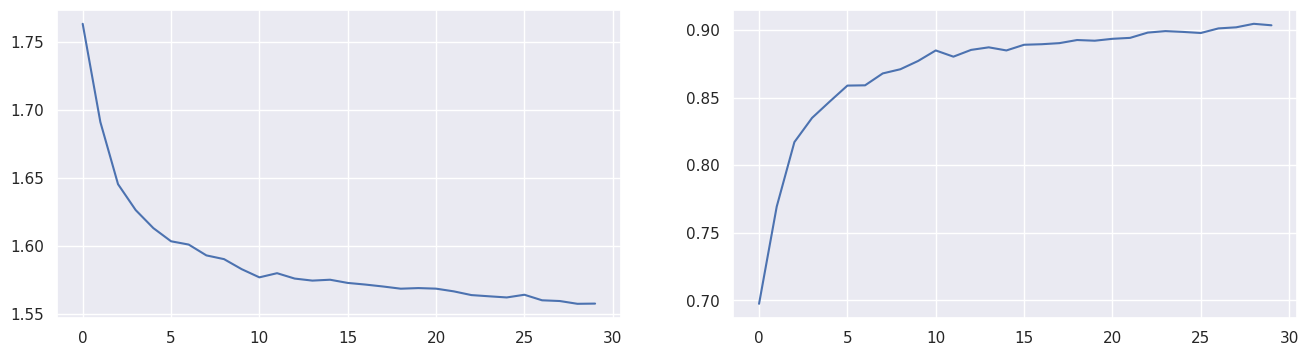

In [130]:
# Non-IID
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('Non-IID | total comm rounds', len(global_acc_list))

In [131]:
noniid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
print(noniid_df)

    global_acc_list                               global_loss_list
0            0.6975  tf.Tensor(1.7635303, shape=(), dtype=float32)
1            0.7694  tf.Tensor(1.6912322, shape=(), dtype=float32)
2            0.8171  tf.Tensor(1.6454821, shape=(), dtype=float32)
3            0.8350   tf.Tensor(1.626408, shape=(), dtype=float32)
4            0.8471  tf.Tensor(1.6131357, shape=(), dtype=float32)
5            0.8589  tf.Tensor(1.6034527, shape=(), dtype=float32)
6            0.8591  tf.Tensor(1.6010292, shape=(), dtype=float32)
7            0.8679  tf.Tensor(1.5930611, shape=(), dtype=float32)
8            0.8710  tf.Tensor(1.5903034, shape=(), dtype=float32)
9            0.8771  tf.Tensor(1.5829068, shape=(), dtype=float32)
10           0.8849  tf.Tensor(1.5768944, shape=(), dtype=float32)
11           0.8803  tf.Tensor(1.5799594, shape=(), dtype=float32)
12           0.8853  tf.Tensor(1.5759932, shape=(), dtype=float32)
13           0.8872  tf.Tensor(1.5745012, shape=(), dtype=floa

In [132]:
compute_dp_sgd_privacy

<module 'tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy' from '/usr/local/lib/python3.10/dist-packages/tensorflow_privacy/privacy/analysis/compute_dp_sgd_privacy.py'>

In [133]:
tensorflow_privacy.compute_dp_sgd_privacy(n=X_train.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=10,
                                              delta=1e-5)

(0.35900103412369533, 25.0)

In [134]:
def calculate_metrics(dishonest_predicted, honest_predicted, all_workers):
    total_workers = len(all_workers)
    total_dishonest = sum(1 for client in all_workers if client.endswith('*'))
    # Correctly identified as dishonest
    TP = sum(1 for client in dishonest_predicted if client.endswith('*'))
    # Incorrectly identified as dishonest
    FP = len(dishonest_predicted) - TP
    # Actual dishonest workers not identified as such
    FN = total_dishonest - TP
    # Correctly identified as honest, assumes total_workers is the sum of dishonest and honest workers
    TN = total_workers - total_dishonest - FP

    # Calculating metrics
    accuracy = (TP + TN) / (total_workers) if (total_workers) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (total_dishonest) if (total_dishonest) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score


def calculate_metrics_from_json(data):
  # Ground truth
  dishonest_workers_gt = [client for client in data['dhw'] if client.endswith('*')] + [client for client in data['ahw'] if client.endswith('*')]
  total_dishonest = len(dishonest_workers_gt)

  # Method 1
  accuracy1, precision1, recall1, f1_score1 = calculate_metrics(data['dhw'], data['hw'], data["aw"])

  # Method 2
  accuracy2, precision2, recall2, f1_score2 = calculate_metrics(data['adhw'], data['hw'], data["aw"])

  print("MKRUM - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(accuracy1, precision1, recall1, f1_score1))
  print("BIASDETECT - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(accuracy2, precision2, recall2, f1_score2))

  return [data["tr"], accuracy1, precision1, recall1, f1_score1, accuracy2, precision2, recall2, f1_score2]


In [135]:
import json
filename=log_file
run_logs = None
with open(filename, 'r') as file:
    logs = json.load(file)


In [136]:
run_logs = logs['run_logs']

In [137]:
scores = []
for data in run_logs:
  round_data = calculate_metrics_from_json(data)
  scores.append(round_data)

MKRUM - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
BIASDETECT - Accuracy: 0.82, Precision: 0.00, Recall: 0.00, F1 Score: 0.00
MKRUM - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
BIASDETECT - Accuracy: 0.87, Precision: 1.00, Recall: 0.28, F1 Score: 0.43
MKRUM - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
BIASDETECT - Accuracy: 0.85, Precision: 1.00, Recall: 0.17, F1 Score: 0.29
MKRUM - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
BIASDETECT - Accuracy: 0.83, Precision: 1.00, Recall: 0.06, F1 Score: 0.11
MKRUM - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
BIASDETECT - Accuracy: 0.99, Precision: 1.00, Recall: 0.94, F1 Score: 0.97
MKRUM - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
BIASDETECT - Accuracy: 0.96, Precision: 1.00, Recall: 0.78, F1 Score: 0.88
MKRUM - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
BIASDETECT - Accuracy: 0.99, Precision: 1.00, Recall: 0.94, 

In [138]:
from pandas import DataFrame
df = DataFrame(scores, columns=['round', 'accuracy1', 'precision1', 'recall1', 'f1_score1', 'accuracy2', 'precision2', 'recall2', 'f1_score2'])
df = df.iloc[1:, :]
df

,round,accuracy1,precision1,recall1,f1_score1,accuracy2,precision2,recall2,f1_score2
1,1,1.0,1.0,1.0,1.0,0.868687,1.000000,0.277778,0.434783
2,2,1.0,1.0,1.0,1.0,0.848485,1.000000,0.166667,0.285714
3,3,1.0,1.0,1.0,1.0,0.828283,1.000000,0.055556,0.105263
4,4,1.0,1.0,1.0,1.0,0.989899,1.000000,0.944444,0.971429
5,5,1.0,1.0,1.0,1.0,0.959596,1.000000,0.777778,0.875000
6,6,1.0,1.0,1.0,1.0,0.989899,1.000000,0.944444,0.971429
7,7,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000
8,8,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000
9,9,1.0,1.0,1.0,1.0,0.989899,0.947368,1.000000,0.972973
10,10,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000


In [139]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index, series1_key, series2_key, algos):
    palette = list(sns.color_palette('Dark2'))  # Use color_palette instead of mpl_palette
    xs = series['round']
    ys1 = series[series1_key]
    ys2 = series[series2_key]

    # Plot accuracy1
    plt.plot(xs, ys1, label=f'{algos[0]} {series_name}', color=palette[series_index % len(palette)])
    # Plot accuracy2 with a different color
    plt.plot(xs, ys2, label=f'{algos[1]} {series_name}', color=palette[(series_index + 1) % len(palette)])


In [140]:
def render_plot(title, series1_key, series2_key):
  fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
  df_1 = df
  df_sorted = df_1.sort_values('round', ascending=True)

  # Assuming _df_8 has columns 'round', 'accuracy1', and 'accuracy2'
  _plot_series(df_sorted, title, 0, series1_key=series1_key, series2_key=series2_key, algos=['MK-K-Means', 'BD'])
  sns.despine(fig=fig, ax=ax)
  plt.xlabel('Round')
  _ = plt.ylabel(title)
  plt.legend()  # Display legend to show series names

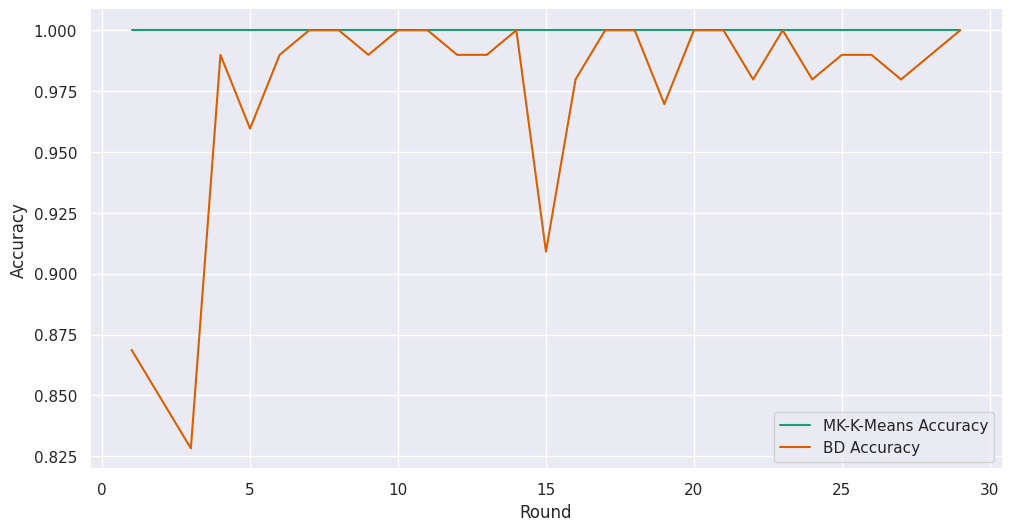

In [141]:
render_plot(title='Accuracy', series1_key='accuracy1', series2_key='accuracy2')

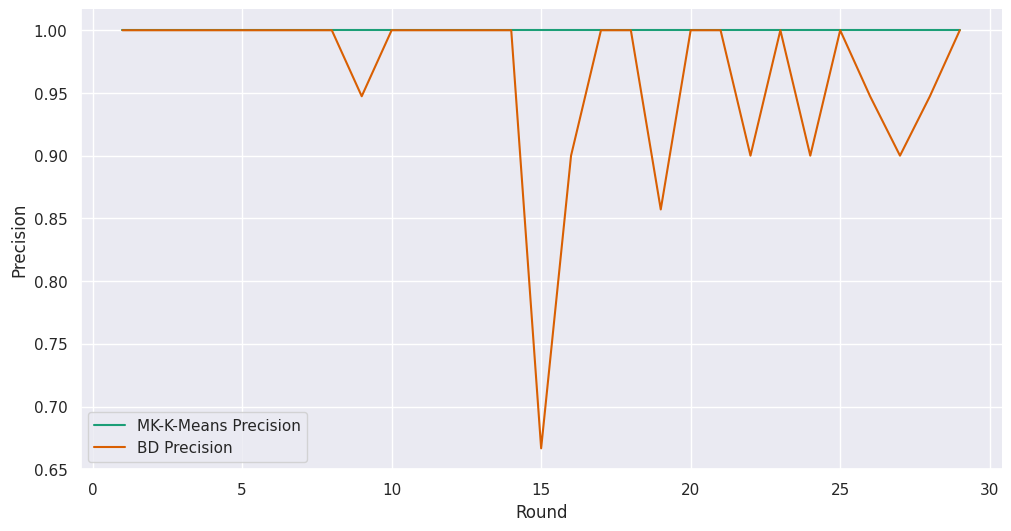

In [142]:
render_plot(title='Precision', series1_key='precision1', series2_key='precision2')

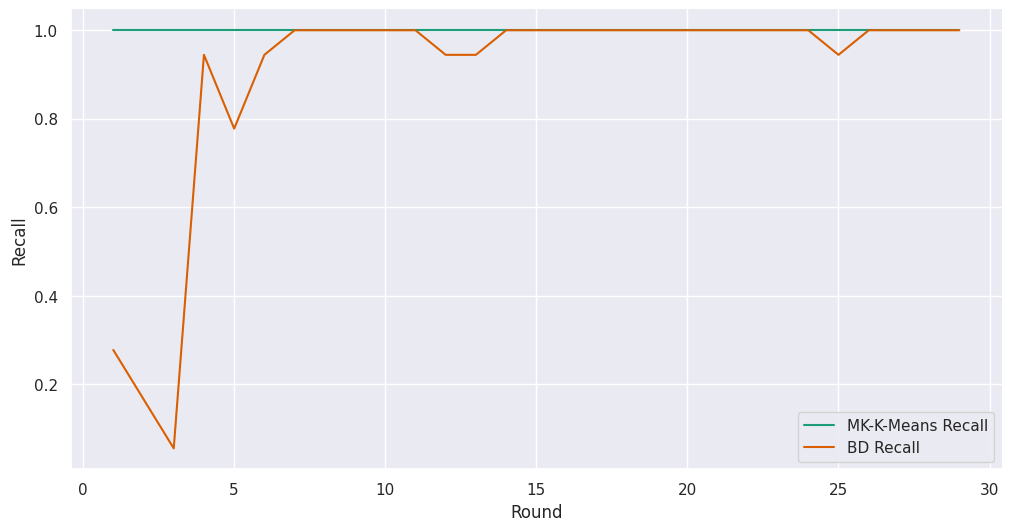

In [143]:
render_plot(title='Recall', series1_key='recall1', series2_key='recall2')

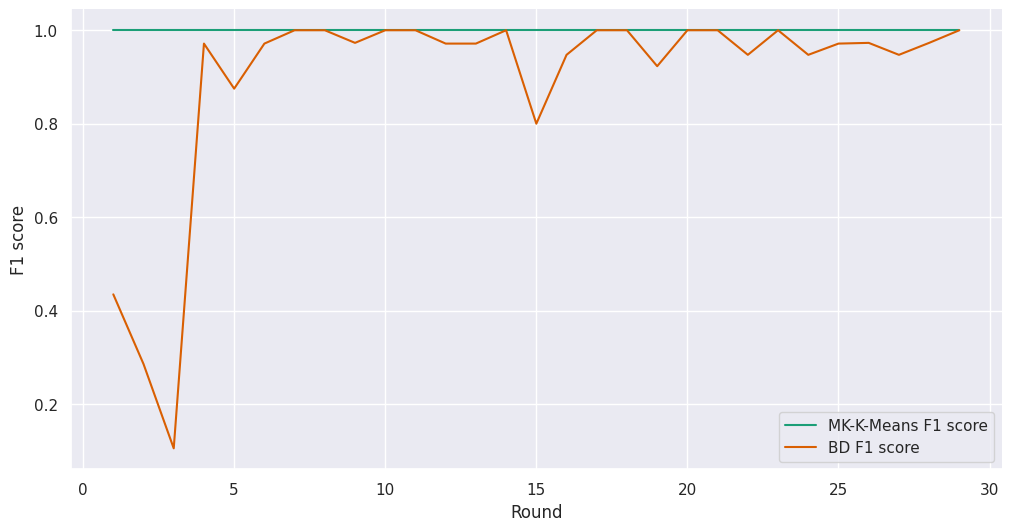

In [144]:
render_plot(title='F1 score', series1_key='f1_score1', series2_key='f1_score2')